# Timeseries checks for quality control flags
Covers QC12-15

These were seperated from comparison checks as they do not explicitly rely on comparison to an index (although they use the SDII)  
These checks deal with accumulations and dry period lengths etc.


## Table of contents
[QC12 CDD](#QC12---CDD)  
[QC13 Daily accumulations](#QC13---Daily-accumulations)  
[QC14 Monthly accumulations](#QC14---Monthly-accumulations)  
[QC15 Streaks](#QC15---Streaks)  

## Notes:
- The ETCCDI data comes from two models(?): GHCNDEX & HADEX2  
- Many of the checks use the same flags so lots of room for writing consise functions


See '3.3.1 Suspiciously high values' in Lewis et al. (2021)

In [1]:
import datetime

import polars as pl
import xarray as xr
import numpy as np

pl.Config.set_tbl_rows(20);

In [2]:
def read_metadata(data_path):
    metadata = {}

    with open(data_path, 'r') as f:
        while True:
            key, val = f.readline().strip().split(':', maxsplit=1)
            key = key.lower().replace(' ', '_')
            metadata[key.strip()] = val.strip()
            if key == 'other':
                break
    return metadata

In [3]:
metadata = read_metadata(data_path='../data/gauge_data/DE_02483.txt')
startdate = datetime.datetime.strptime(metadata['start_datetime'], '%Y%m%d%H')
enddate = datetime.datetime.strptime(metadata['end_datetime'], '%Y%m%d%H')

In [4]:
rain_col = f'rain_{metadata['original_units']}'

In [5]:
def get_delta(d1, d2):
    delta = d2 - d1
    return delta


hourly_date_interval = []
delta = get_delta(startdate, enddate+datetime.timedelta(days=1))
for i in range(delta.days * 24):
    hourly_date_interval.append(startdate + datetime.timedelta(hours=i))

In [6]:
gauge_data = pl.read_csv('../data/gauge_data/DE_02483.txt', skip_rows=20)

assert len(gauge_data) == len(hourly_date_interval)

## set time columns
gauge_data = gauge_data.with_columns(time=pl.Series(hourly_date_interval))

## Rename
gauge_data = gauge_data.rename({'Other: ': rain_col})

## Reorder (to look nice)
gauge_data = gauge_data.select(['time', rain_col])

In [7]:
## make no data vals nans
gauge_data = gauge_data.with_columns(pl.when(pl.col(rain_col) == int(metadata['no_data_value'])).then(np.nan).otherwise(pl.col(rain_col)).alias(rain_col))

### World records

In [8]:
# *** updated to use 401.0 mm in 1 hour - compare e.g.
# http://www.nws.noaa.gov/oh/hdsc/record_precip/record_precip_world.html
# http://www.bom.gov.au/water/designRainfalls/rainfallEvents/worldRecRainfall.shtml
# https://wmo.asu.edu/content/world-meteorological-organization-global-weather-climate-extremes-archive

world_records = {'hourly': 401.0, 'daily': 1825.0}  # mm

# QC12 - CDD 
[Back to Index](#Table-of-contents)

#### Differences from `intense-qc`: 
- Include starts and end of dry spell checks
- Also using polars rather than lists (should be much quicker)

#### Notes on testing:
- Need to test for single and multiple dry spells

In [9]:
etccdi_cdd = xr.open_dataset('../data/ETCCDI/RawData_HADEX2_CDD_1951-2010_ANN_from-90to90_from-180to180.nc')
etccdi_cdd

/tmp/ipykernel_20283/1597129515.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  etccdi_cdd = xr.open_dataset('../data/ETCCDI/RawData_HADEX2_CDD_1951-2010_ANN_from-90to90_from-180to180.nc')


<xarray.Dataset> Size: 3MB
Dimensions:  (time: 60, lat: 73, lon: 96)
Coordinates:
  * time     (time) datetime64[ns] 480B 1951-01-01 1952-01-01 ... 2010-01-01
  * lat      (lat) float32 292B -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float32 384B -180.0 -176.2 -172.5 ... 168.8 172.5 176.2
Data variables:
    CDD      (time, lat, lon) timedelta64[ns] 3MB ...
Attributes:
    title:          HADEX2 CDD ANN 1951-2010
    reference:      Donat, M. G., et al. (2013), Updated analyses of temperat...
    copyright:      www.climdex.org
    creation_date:  Sun Mar 25 09:00:26 AEDT 2018

In [10]:
## Conversion from intense
etccdi_cdd_vals = etccdi_cdd['CDD'].values.astype('timedelta64[s]').astype('float32') / 86400.0 # seconds in a day
etccdi_cdd_vals[etccdi_cdd_vals < 0.0] = np.nan ## This is a quick way to mask out non-land

## Below has been added since original method
print(f'Number of cells above 366 days per year {[etccdi_cdd_vals > 366][0].sum()}')
etccdi_cdd_vals[etccdi_cdd_vals > 366] = np.nan ## remove errors

etccdi_cdd_vals = np.ma.masked_invalid(etccdi_cdd_vals)
etccdi_cdd['CDD_days'] = (('lat', 'lon'), np.ma.max(etccdi_cdd_vals, axis=0))


Number of cells above 366 days per year 36


/tmp/ipykernel_20283/2790510670.py:2: SerializationWarning: Can't decode floating point timedelta to 's' without precision loss, decoding to 'ns' instead. To silence this warning use time_unit='ns' in call to decoding function.
  etccdi_cdd_vals = etccdi_cdd['CDD'].values.astype('timedelta64[s]').astype('float32') / 86400.0 # seconds in a day


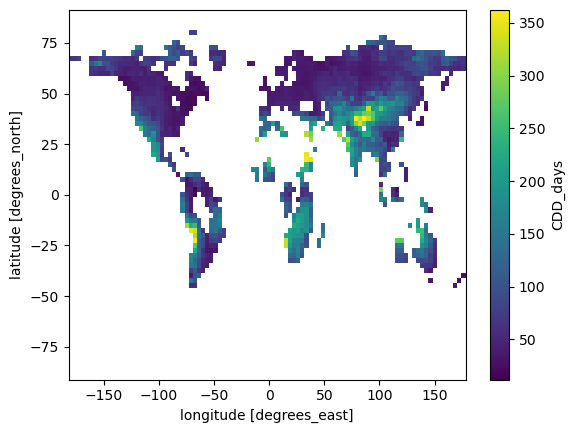

In [11]:
etccdi_cdd['CDD_days'].plot() ## before there were clearly some errors (as only ~365 days in year)

In [12]:
one_gauge_cdd = etccdi_cdd.sel(lon=metadata['longitude'], lat=metadata['latitude'], method='nearest')

In [13]:
max_cdd = np.max(one_gauge_cdd['CDD_days'])
max_cdd.data # 36.85 days

array(36.85967636)

In [14]:
## get dry spells and their legnths
gauge_data_dry_spells = gauge_data.with_columns(
    (pl.col(rain_col) == 0).cast(pl.Int8()).alias("is_zero"),
    )


gauge_data_dry_spell_groups = gauge_data_dry_spells.with_columns(
        ((pl.col("is_zero").diff().fill_null(0) == 1).cum_sum()).alias("group_id")
    )

In [15]:
gauge_data_dry_spell_lengths = gauge_data_dry_spell_groups.filter(pl.col("is_zero") == 1)\
        .group_by("group_id")\
        .agg(
            pl.first("time").alias("dry_spell_start"),
            pl.last("time").alias("dry_spell_end"),
            pl.col("is_zero").sum().alias("dry_spell_length_h")
            )\
        .sort("group_id")

In [16]:
gauge_data_dry_spell_lengths

group_id,dry_spell_start,dry_spell_end,dry_spell_length_h
u32,datetime[μs],datetime[μs],i64
1,2006-01-01 03:00:00,2006-01-01 07:00:00,5
2,2006-01-01 09:00:00,2006-01-01 09:00:00,1
3,2006-01-01 11:00:00,2006-01-01 13:00:00,3
4,2006-01-01 16:00:00,2006-01-11 16:00:00,241
5,2006-01-11 23:00:00,2006-01-17 08:00:00,130
6,2006-01-17 10:00:00,2006-01-17 11:00:00,2
7,2006-01-17 23:00:00,2006-01-18 00:00:00,2
8,2006-01-18 05:00:00,2006-01-18 05:00:00,1
9,2006-01-18 07:00:00,2006-01-18 07:00:00,1


In [17]:
gauge_data_dry_spell_lengths.filter(pl.col('dry_spell_length_h')/24 > max_cdd)

group_id,dry_spell_start,dry_spell_end,dry_spell_length_h
u32,datetime[μs],datetime[μs],i64
1480,2009-05-31 08:00:00,2009-08-30 23:00:00,2200


In [18]:
dry_spell_lengths_in_days = gauge_data_dry_spell_lengths['dry_spell_length_h']/24

In [19]:
## May need to rethink how this is done uniformly (as could use day check)
gauge_data_dry_spell_lengths_flags = gauge_data_dry_spell_lengths.with_columns(
    pl.when(pl.col("dry_spell_length_h")/24 >= max_cdd * 1.5).then(4)
    .when(pl.col("dry_spell_length_h")/24 >= max_cdd * 1.33).then(3)
    .when(pl.col("dry_spell_length_h")/24 >= max_cdd * 1.2).then(2)
    .when(pl.col("dry_spell_length_h")/24 >= max_cdd).then(1)
    .otherwise(0)
    .alias("dry_spell_flag")
)

In [20]:
gauge_data_dry_spell_lengths_flags['dry_spell_flag'].plot.line()

alt.Chart(...)

In [21]:
gauge_data_errored_data = gauge_data_dry_spell_lengths_flags.filter(
    pl.col('dry_spell_flag') > 0
    )


In [22]:
gauge_data_errored_data

group_id,dry_spell_start,dry_spell_end,dry_spell_length_h,dry_spell_flag
u32,datetime[μs],datetime[μs],i64,i32
1480,2009-05-31 08:00:00,2009-08-30 23:00:00,2200,4


In [23]:
dry_spell_flag_data = pl.DataFrame({
    "time": gauge_data['time'],
    "dry_spell_flag": np.zeros(gauge_data['time'].shape)
})


In [24]:
for errored_data_row in gauge_data_errored_data.iter_rows():
    ## overwrite flag
    dry_spell_flag_data = dry_spell_flag_data.with_columns(
       pl.when((pl.col("time") >= errored_data_row[1]) & (pl.col("time") <= errored_data_row[2]))
        .then(errored_data_row[4])
        .otherwise(pl.col("dry_spell_flag"))
        .alias("dry_spell_flag")
)

In [25]:
errored_data_row[2] + datetime.timedelta(hours=1)

datetime.datetime(2009, 8, 31, 0, 0)

In [26]:
dry_spell_flag_data.filter(
    (pl.col("time") >= errored_data_row[1] - datetime.timedelta(hours=1)) & (pl.col("time") <= errored_data_row[2] + datetime.timedelta(hours=1))
)

time,dry_spell_flag
datetime[μs],f64
2009-05-31 07:00:00,0.0
2009-05-31 08:00:00,4.0
2009-05-31 09:00:00,4.0
2009-05-31 10:00:00,4.0
2009-05-31 11:00:00,4.0
2009-05-31 12:00:00,4.0
2009-05-31 13:00:00,4.0
2009-05-31 14:00:00,4.0
2009-05-31 15:00:00,4.0


# QC13 - Daily accumulations
[Back to Index](#Table-of-contents)

Uses simple precipitation intensity index (SDII)


"Suspect daily accumulations flagged where a recorded rainfall amount at these times is preceded by 23 hours with no rain.  
A threshold of 2x the mean wet day amount for the corresponding month is applied to increase the chance of identifying  
accumulated values at the expense of genuine, moderate events."


## Potential problems:
- Not sure if the description is what the code does
- *IMPORTANT:* does not actually need SDII data as it will ignore it if it is nan

#### Notes on implementation:
- Duration of dry period in hours is from start of hour to following hour i.e. dry spell of start/end of 3pm/7pm is 5 hours as calc to start of 8pm

#### Differences from `intense-qc`: 
- 

In [27]:
etccdi_sdii = xr.open_dataset('../data/ETCCDI/RawData_HADEX2_SDII_1951-2010_ANN_from-90to90_from-180to180.nc')
etccdi_sdii

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 60, lat: 73, lon: 96)
Coordinates:
  * time     (time) datetime64[ns] 480B 1951-01-01 1952-01-01 ... 2010-01-01
  * lat      (lat) float32 292B -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float32 384B -180.0 -176.2 -172.5 ... 168.8 172.5 176.2
Data variables:
    SDII     (time, lat, lon) float32 2MB ...
Attributes:
    title:          HADEX2 SDII ANN 1951-2010
    reference:      Donat, M. G., et al. (2013), Updated analyses of temperat...
    copyright:      www.climdex.org
    creation_date:  Thu Oct 31 03:25:19 AEDT 2019

In [28]:
etccdi_sdii_vals = np.ma.masked_invalid(etccdi_sdii['SDII'])
etccdi_sdii['SDII_mean'] = (('lat', 'lon'), np.ma.mean(etccdi_sdii_vals, axis=0)) # axis 0 should be time

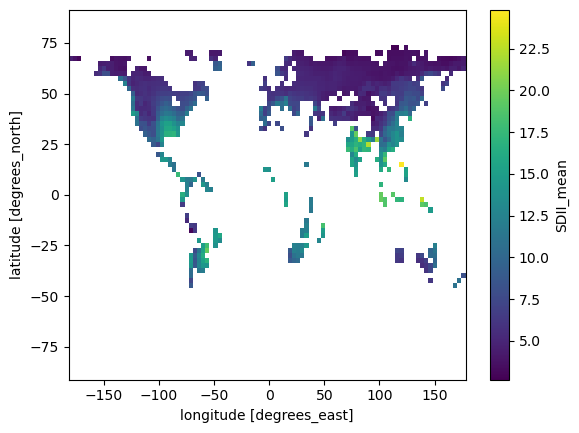

In [29]:
etccdi_sdii['SDII_mean'].plot()

In [30]:
one_gauge_sdii = etccdi_sdii.sel(lon=metadata['longitude'], lat=metadata['latitude'], method='nearest')

In [31]:
one_gauge_sdii

<xarray.Dataset> Size: 736B
Dimensions:    (time: 60)
Coordinates:
  * time       (time) datetime64[ns] 480B 1951-01-01 1952-01-01 ... 2010-01-01
    lat        float32 4B 50.0
    lon        float32 4B 7.5
Data variables:
    SDII       (time) float32 240B 5.881 6.046 5.381 5.673 ... 5.671 5.939 5.973
    SDII_mean  float64 8B 5.982
Attributes:
    title:          HADEX2 SDII ANN 1951-2010
    reference:      Donat, M. G., et al. (2013), Updated analyses of temperat...
    copyright:      www.climdex.org
    creation_date:  Thu Oct 31 03:25:19 AEDT 2019

In [32]:
max_sdii = np.max(one_gauge_sdii['SDII_mean'])
max_sdii.data

array(5.98157705)

In [33]:
gauge_data_nowr = gauge_data.with_columns(
    pl.when(pl.col(rain_col) > world_records['hourly'])
    .then(np.nan)
    .otherwise(pl.col(rain_col))
    .alias(rain_col)
)

In [34]:
## Difference from original is that original does resample, here we do groupby
gauge_data_nowr = gauge_data_nowr.group_by_dynamic('time', every='1d').agg(pl.col(rain_col).sum())

In [35]:
gauge_data_nowr = gauge_data_nowr.with_columns(
    pl.when(pl.col(rain_col) > world_records['daily'])
    .then(np.nan)
    .otherwise(pl.col(rain_col))
    .alias(rain_col)
)

In [36]:
## Calculate Simple precipitation intensity index (SDII)
WET_DAY_THRESHOLD = 1.0

gauge_data_prcp_sum = gauge_data_nowr.filter(
    pl.col(rain_col) >= WET_DAY_THRESHOLD
    ).fill_nan(0.0).sum()[rain_col][0]

gauge_data_wetday_count = gauge_data_nowr.filter(
    pl.col(rain_col) >= WET_DAY_THRESHOLD
    ).fill_nan(0.0).count()[rain_col][0]

sdii_gauge = gauge_data_prcp_sum / float(gauge_data_wetday_count)
sdii_gauge # temperate regions might be between 5-15

12.437812500000001

In [37]:
## to refactor from OG method
sdii_value = max_sdii # OG backup is sdii_gauge

def daily_accums_day_check(day_val_list, sdii_value):
    flag = 0
    if day_val_list[23] > 0:
        dry_hours = 0
        for i in range(23):
            if day_val_list[i] <= 0:
                dry_hours += 1
        if dry_hours == 23:
            if day_val_list[23] > sdii_value:
                flag = 1
    return flag

In [38]:
## Note uses 24 hour moving window
vals = gauge_data[rain_col]
flags = np.zeros_like(vals)
# flags = [0 for i in range(len(gauge_data[rain_col]))]

for i in range(len(vals) - 24):
    day_val_list = vals[i:i + 24]
    flag = daily_accums_day_check(day_val_list, sdii_value)
    if flag > max(flags[i:i + 24]):
        flags[i:i + 24] = np.full(24, flag)


In [39]:
np.unique(flags, return_counts=True)

(array([0., 1.]), array([43248,   576]))

# QC14 - Monthly accumulations 
[Back to Index](#Table-of-contents)

#### Differences from `intense-qc`: 
- Removed check for values less than 720 hours as I believe this method could be more dynamic and combine with daily accumulation

#### Notes on implementation:
- Duration of dry period in hours is from start of hour to following hour i.e. dry spell of start/end of 3pm/7pm is 5 hours as calc to start of 8pm. I.e. 3pm only would be dry period of length == 1
- 720 hours used but that is 30 days not a month

**NOTE:** SDII data loaded-in in [QC13](#qc13---daily-accumulations) 

In [40]:
possible_accumulation_threshold = max_sdii * 2.0

In [41]:
# Step 1: Detect streaks of consecutive zeros
gauge_data_zeros = gauge_data.with_columns(
    (pl.col(rain_col) == 0).cast(pl.Int8()).alias("is_zero")
)

gauge_data_zeros_groups =  gauge_data_zeros.with_columns(
    (pl.col("is_zero").diff().fill_null(0) != 0).cum_sum().alias("group_id")
)

In [42]:
## Get first wet value after consecutive zeros
gauge_data_zeros_groups = gauge_data_zeros_groups.with_columns(
    pl.when((pl.col("is_zero") == 0) & (pl.col("group_id").diff().fill_null(0) == 1))
    .then(pl.col("time"))
    .otherwise(None)
    .alias("first_wet_after_zero")
)


In [43]:
gauge_data_zeros_groups.head(10)

time,rain_mm,is_zero,group_id,first_wet_after_zero
datetime[μs],f64,i8,u32,datetime[μs]
2006-01-01 00:00:00,0.9,0,0,null
2006-01-01 01:00:00,0.3,0,0,null
2006-01-01 02:00:00,0.3,0,0,null
2006-01-01 03:00:00,0.0,1,1,null
2006-01-01 04:00:00,0.0,1,1,null
2006-01-01 05:00:00,0.0,1,1,null
2006-01-01 06:00:00,0.0,1,1,null
2006-01-01 07:00:00,0.0,1,1,null
2006-01-01 08:00:00,0.9,0,2,2006-01-01 08:00:00


In [44]:
## Get dry spell lengths
gauge_data_dry_spell_lengths = gauge_data_zeros_groups.filter(pl.col("is_zero") == 1)\
        .group_by("group_id")\
        .agg(
            pl.first("time").alias("dry_spell_start"),
            pl.last("time").alias("dry_spell_end"),
            pl.col("is_zero").sum().alias("dry_spell_length_h")
            )\
        .sort("group_id")

In [45]:
gauge_data_dry_spell_all_info = gauge_data_zeros_groups.join(gauge_data_dry_spell_lengths, on='group_id', how='left')

In [46]:
gauge_data_dry_spell_all_info.head(10)

time,rain_mm,is_zero,group_id,first_wet_after_zero,dry_spell_start,dry_spell_end,dry_spell_length_h
datetime[μs],f64,i8,u32,datetime[μs],datetime[μs],datetime[μs],i64
2006-01-01 00:00:00,0.9,0,0,null,null,null,null
2006-01-01 01:00:00,0.3,0,0,null,null,null,null
2006-01-01 02:00:00,0.3,0,0,null,null,null,null
2006-01-01 03:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5
2006-01-01 04:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5
2006-01-01 05:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5
2006-01-01 06:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5
2006-01-01 07:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5
2006-01-01 08:00:00,0.9,0,2,2006-01-01 08:00:00,null,null,null


In [47]:
gauge_data_dry_spell_all_info['dry_spell_length_h'].hist()

breakpoint,category,count
f64,cat,u32
220.9,"""(-1.199, 220.9]""",26920
440.8,"""(220.9, 440.8]""",3819
660.7,"""(440.8, 660.7]""",458
880.6,"""(660.7, 880.6]""",1467
1100.5,"""(880.6, 1100.5]""",0
1320.4,"""(1100.5, 1320.4]""",0
1540.3,"""(1320.4, 1540.3]""",0
1760.2,"""(1540.3, 1760.2]""",0
1980.1,"""(1760.2, 1980.1]""",0


In [48]:
## OG method subsets by 720 days (but I am assuming they mean 720 hours so that is 30 days, but what about months with 31 days)
# gauge_data_dry_spell_all_info = gauge_data_dry_spell_all_info.filter(
#     pl.col('dry_spell_length_h').fill_null(0.0) <= 720
# )

In [49]:
gauge_data_dry_spell_all_info.head(8)

time,rain_mm,is_zero,group_id,first_wet_after_zero,dry_spell_start,dry_spell_end,dry_spell_length_h
datetime[μs],f64,i8,u32,datetime[μs],datetime[μs],datetime[μs],i64
2006-01-01 00:00:00,0.9,0,0,null,null,null,null
2006-01-01 01:00:00,0.3,0,0,null,null,null,null
2006-01-01 02:00:00,0.3,0,0,null,null,null,null
2006-01-01 03:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5
2006-01-01 04:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5
2006-01-01 05:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5
2006-01-01 06:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5
2006-01-01 07:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5


In [50]:
### Get values that are double SDII daily in one hour

gauge_data_dry_spell_all_info_possible_accum = gauge_data_dry_spell_all_info.with_columns(
    pl.when(pl.col('dry_spell_end') == pl.col('time'))
    .then(pl.col(rain_col).shift(-1).fill_nan(0.0) > possible_accumulation_threshold)
    .otherwise(np.nan)
    .alias('possible_accumulation')
)

In [51]:
## Shift the value along
gauge_data_dry_spell_all_info_possible_accum = gauge_data_dry_spell_all_info_possible_accum.with_columns(
    possible_accumulation=pl.col('possible_accumulation').shift(1)
)

In [52]:
gauge_data_dry_spell_all_info_possible_accum.head(10)

time,rain_mm,is_zero,group_id,first_wet_after_zero,dry_spell_start,dry_spell_end,dry_spell_length_h,possible_accumulation
datetime[μs],f64,i8,u32,datetime[μs],datetime[μs],datetime[μs],i64,f64
2006-01-01 00:00:00,0.9,0,0,null,null,null,null,null
2006-01-01 01:00:00,0.3,0,0,null,null,null,null,NaN
2006-01-01 02:00:00,0.3,0,0,null,null,null,null,NaN
2006-01-01 03:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5,NaN
2006-01-01 04:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5,NaN
2006-01-01 05:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5,NaN
2006-01-01 06:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5,NaN
2006-01-01 07:00:00,0.0,1,1,null,2006-01-01 03:00:00,2006-01-01 07:00:00,5,NaN
2006-01-01 08:00:00,0.9,0,2,2006-01-01 08:00:00,null,null,null,0.0


In [53]:
gauge_data_dry_spell_all_info_possible_accum['possible_accumulation'].value_counts()

possible_accumulation,count
f64,u32
0.0,1957
null,1
NaN,41841
1.0,25


In [54]:
## add column for previous dry spell
gauge_data_dry_spell_all_info_possible_accum = gauge_data_dry_spell_all_info_possible_accum.with_columns(
    prev_dry_spell=pl.col('dry_spell_length_h').shift(1),
    next_dry_spell=pl.col('dry_spell_length_h').shift(-1)
)

In [55]:
all_possible_accumulations = gauge_data_dry_spell_all_info_possible_accum.filter(
    (pl.col('possible_accumulation') == 1)
)

In [56]:
all_possible_accumulations

time,rain_mm,is_zero,group_id,first_wet_after_zero,dry_spell_start,dry_spell_end,dry_spell_length_h,possible_accumulation,prev_dry_spell,next_dry_spell
datetime[μs],f64,i8,u32,datetime[μs],datetime[μs],datetime[μs],i64,f64,i64,i64
2006-06-14 16:00:00,12.4,0,462,2006-06-14 16:00:00,null,null,null,1.0,305,14
2006-06-25 19:00:00,15.0,0,484,2006-06-25 19:00:00,null,null,null,1.0,86,null
2006-07-07 17:00:00,17.2,0,500,2006-07-07 17:00:00,null,null,null,1.0,1,null
2006-07-22 17:00:00,13.0,0,508,2006-07-22 17:00:00,null,null,null,1.0,25,null
2006-07-27 13:00:00,22.4,0,512,2006-07-27 13:00:00,null,null,null,1.0,30,null
2006-07-30 20:00:00,13.5,0,522,2006-07-30 20:00:00,null,null,null,1.0,2,1
2006-08-01 18:00:00,22.6,0,530,2006-08-01 18:00:00,null,null,null,1.0,1,null
2006-12-24 01:00:00,450.0,0,908,2006-12-24 01:00:00,null,null,null,1.0,65,null
2007-03-16 12:00:00,75.0,0,1138,2007-03-16 12:00:00,null,null,null,1.0,157,17


In [57]:
all_possible_accumulations['prev_dry_spell'].value_counts().sort('prev_dry_spell')

prev_dry_spell,count
i64,u32
1,5
2,1
22,1
23,4
24,1
25,1
26,1
30,1
34,1


In [58]:
all_possible_accumulations['next_dry_spell'].value_counts().sort('next_dry_spell')

next_dry_spell,count
i64,u32
null,12
1,1
3,1
13,1
14,1
17,1
23,4
33,1
40,1


In [59]:
## 3720 has odd profile perhaps a typo in measurement? or very sudden heavy rainfall
## 3674-3680 is likely daily accumulation
gauge_data_dry_spell_all_info_possible_accum.filter(
    (pl.col('group_id') >= 3720-2) & (pl.col('group_id') < 3720+1)
)

time,rain_mm,is_zero,group_id,first_wet_after_zero,dry_spell_start,dry_spell_end,dry_spell_length_h,possible_accumulation,prev_dry_spell,next_dry_spell
datetime[μs],f64,i8,u32,datetime[μs],datetime[μs],datetime[μs],i64,f64,i64,i64
2010-08-26 21:00:00,0.2,0,3718,2010-08-26 21:00:00,null,null,null,0.0,6,null
2010-08-26 22:00:00,0.3,0,3718,null,null,null,null,NaN,null,null
2010-08-26 23:00:00,0.2,0,3718,null,null,null,null,NaN,null,null
2010-08-27 00:00:00,0.8,0,3718,null,null,null,null,NaN,null,null
2010-08-27 01:00:00,1.3,0,3718,null,null,null,null,NaN,null,null
2010-08-27 02:00:00,0.2,0,3718,null,null,null,null,NaN,null,1
2010-08-27 03:00:00,0.0,1,3719,null,2010-08-27 03:00:00,2010-08-27 03:00:00,1,NaN,null,null
2010-08-27 04:00:00,13.7,0,3720,2010-08-27 04:00:00,null,null,null,1.0,1,null
2010-08-27 05:00:00,2.3,0,3720,null,null,null,null,NaN,null,null


# QC15 - Streaks 
[Back to Index](#Table-of-contents)

#### Differences from `intense-qc`: 
- 

**NOTE:** SDII data loaded-in in [QC13](#qc13---daily-accumulations) 